# Login to Google Drive account - file in folder content/drive/MyDrive/


1.  Training Yolov3 and yolov3 tiny
2.  Training Yolov4 and yolov4 tiny

3. Evaluation trained yolo weights
4. Trackers and weights converions


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 
!ln -s  /content/drive/My\ Drive/ /mydrive  
!ls /mydrive

Mounted at /content/drive
'Colab Notebooks'  'My Drive'	     Tracker		      yolov3
 cv2_gpu	    stitched21.mp4   Tracker-Yolov3DeepSort   yolov4


In [ ]:
# This cell ensures you have the correct architecture for your respective GPU
# If you command is not found, look through these GPUs, find the respective
# GPU and add them to the archTypes dictionary
import os
os.environ['GPU_TYPE'] = str(os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read())
def getGPUArch(argument):
  try:
    argument = argument.strip()
    # All Colab GPUs
    archTypes = {
        "Tesla V100-SXM2-16GB": "-gencode arch=compute_70,code=[sm_70,compute_70]",
        "Tesla K80": "-gencode arch=compute_37,code=sm_37",
        "Tesla T4": "-gencode arch=compute_75,code=[sm_75,compute_75]",
        "Tesla P40": "-gencode arch=compute_61,code=sm_61",
        "Tesla P4": "-gencode arch=compute_61,code=sm_61",
        "Tesla P100-PCIE-16GB": "-gencode arch=compute_60,code=sm_60"}
    return archTypes[argument]
  except KeyError:
    return "GPU must be added to GPU Commands"
os.environ['ARCH_VALUE'] = getGPUArch(os.environ['GPU_TYPE'])
print("GPU Type: " + os.environ['GPU_TYPE'])
print("ARCH Value: " + os.environ['ARCH_VALUE'])

GPU Type: Tesla K80

ARCH Value: -gencode arch=compute_37,code=sm_37


In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Mon May 31 23:45:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     8W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# CUDA: check which version of Nvidia CUDA drivers are already pre-installed
!/usr/local/cuda/bin/nvcc --version


#**TRAINING custom CNN from darknet pretrained weights**

## 1. YOLOV3 and YOLOV3-tiny

### **YOLOv3 and YOLOV3 tiny training and configuration**

**1) Clone, configure & compile Darknet**

In [ ]:
# Clone
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15054, done.
remote: Total 15054 (delta 0), reused 0 (delta 0), pack-reused 15054
Receiving objects: 100% (15054/15054), 13.40 MiB | 15.84 MiB/s, done.
Resolving deltas: 100% (10233/10233), done.


In [ ]:
# Configure
%cd /content/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile #to build with OpenCV 3.x/2.4.x - allows to detect on video files and video streams from network cameras or web-cams
!sed -i 's/GPU=0/GPU=1/' Makefile # to build with CUDA to accelerate by using GPU (CUDA should be in /usr/local/cuda)
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile #to build with cuDNN v5-v7 to accelerate training by using GPU (cuDNN should be in /usr/local/cudnn)
!sed -i 's/DEBUG=0/DEBUG=1/' Makefile  #to bould debug version of Yolo
#!sed -i 's/OPENMP=0/OPENMP=1/' Makefile #OPENMP=1 to build with OpenMP support to accelerate Yolo by using multi-core CPU

/content/darknet


In [ ]:
# Compile
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DDEBUG -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -DDEBUG -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
            

**2) Configure yolov3.cfg file setting class objects and epochs** 

In [ ]:
# Make a copy of yolov3.cfg or yolov3-tiny.cfg [change below to set tiny version]
!cp /content/darknet/cfg/yolov3.cfg cfg/yolov3_training.cfg 
%cd /content/darknet/
#!cp cfg/yolov3_training.cfg /content/drive/MyDrive/yolov3  SAVE .cfg [network structure and configuration file to drive]

cp: cannot create regular file 'cfg/yolov3_training.cfg': No such file or directory
/content/darknet


In [ ]:
# Change lines in yolov3.cfg file 
!sed -i 's/batch=1/batch=64/' cfg/yolov3_training.cfg     #use -tiny-tiny-tiny-tiny-tiny-tiny-tiny-tiny-tiny-tiny in all lines below 
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg 
!sed -i 's/max_batches = 500200/max_batches = 6000/' cfg/yolov3_training.cfg
!sed -i '610 s@classes=80@classes=3@' cfg/yolov3_training.cfg
!sed -i '696 s@classes=80@classes=3@' cfg/yolov3_training.cfg
!sed -i '783 s@classes=80@classes=3@' cfg/yolov3_training.cfg
!sed -i '603 s@filters=255@filters=24@' cfg/yolov3_training.cfg
!sed -i '689 s@filters=255@filters=24@' cfg/yolov3_training.cfg
!sed -i '776 s@filters=255@filters=24@' cfg/yolov3_training.cfg

**3) Create a folder and unzip image dataset imported from roboflow**

In [ ]:
# Export code snippet and paste here
##ROBOFLOW DATASET WITH TRAINING DATA/FRAMES
!mkdir /content/darknet/data/obj9
%cd /content/darknet/data/obj
!curl -L !curl -L "COPY-PASTEHERETHELINKFROMWEBSITE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/image_000018_jpeg.rf.bf142d0f55ff6fb0df25f9cfdd11469c.jpg  
 extracting: train/image_000018_jpeg.rf.bf142d0f55ff6fb0df25f9cfdd11469c.txt  
 extracting: train/image_000019_jpeg.rf.2ddb2ecaf4c4c3bd536d0f8ed94742e8.jpg  
 extracting: train/image_000019_jpeg.rf.2ddb2ecaf4c4c3bd536d0f8ed94742e8.txt  
 extracting: train/image_000019_jpeg.rf.2f78bf11de2a8daf8e6ac6faf4aa9909.jpg  
 extracting: train/image_000019_jpeg.rf.2f78bf11de2a8daf8e6ac6faf4aa9909.txt  
 extracting: train/image_000020_jpeg.rf.64c03a0521369066197e56ccda4cdfb9.jpg  
 extracting: train/image_000020_jpeg.rf.64c03a0521369066197e56ccda4cdfb9.txt  
 extracting: train/image_000020_jpeg.rf.78f76535c6a3d04a8ec49802103e5f80.jpg  
 extracting: train/image_000020_jpeg.rf.78f76535c6a3d04a8ec49802103e5f80.txt  
 extracting: train/image_000021_jpeg.rf.2e231dcc2d33ead26fbfc0de43263656.jpg  
 extracting: train/image_000021_jpeg.rf.2e231dcc2d33ead26fbfc0de43263656.txt  
 

**4) Create train.txt and test.txt file - link to images for training and validation** 

In [ ]:
##2 methods - run cell below to create both valid, for testing and test.txt files with locations of pictures in the dataset
import glob
#types = ('data/obj/*.jpeg') #, 'data/obj/*.jpg' the tuple of file types
#for files in types:
 #  images_list =glob.glob(files)
images_list = glob.glob("/content/darknet/data/obj/train/**.jpg")
with open("/content/darknet/data/train.txt", "w") as f:
    f.write("\n".join(images_list))

valid_list = glob.glob("/content/darknet/data/obj/test/**.jpg")
with open("/content/darknet/data/test.txt", "w") as f:
    f.write("\n".join(valid_list))

test_list = glob.glob("/content/darknet/data/obj/valid/**.jpg")
with open("/content/darknet/data/test.txt", "w") as f:
    f.write("\n".join(valid_list))

**5) Create .names(researcher, rat, head) and .data([path to images folder and network setting) files - output weights set to folder in drive (/content/drive/MyDrive/yolov3)**

In [ ]:
#!echo -e 'researcher\nrat\nhead' > /content/darknet/data/obj.names
#Set up training file directories for custom dataset
%cd /content/darknet/
%cp /content/darknet/data/obj/train/_darknet.labels data/obj.names
#%mkdir data/obj
!echo -e 'classes= 3\ntrain  = data/train.txt\nvalid  = data/test.txt\nnames = data/obj.names\nbackup = /content/drive/MyDrive/yolov3' > /content/darknet/data/obj.data

/content/darknet


**6) Save yolov3_training.cfg and obj.names files in Google drive - not necessary after first time**

In [ ]:
##Already saved in MyDrive/yolov3-tiny - Run if first time training
#!cp /content/darknet/cfg/yolov4_training.cfg /content/drive/MyDrive/yolov3/yolov4_training.cfg #yolov3-tiny_training.cfg 
!cp /content/darknet/data/obj.names /content/drive/MyDrive/yolov3/obj.names

**7) Download pre-trained weights for the convolutional layers file**

In [ ]:
##run only if first time training
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2021-05-20 19:01:50--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  64.8MB/s    in 2.4s    

2021-05-20 19:01:53 (64.8 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



**8) Start training (-map show training accuracy progession, calculate every 1000 iterations)**

In [ ]:
##CHECK darknet/data/obj.data FILE - backub=  /content/drive/MyDrive/yolov3 
#!./darknet detector train data/obj.data cfg/yolov3-tiny_training.cfg darknet53.conv.74 -dont_show -map ##uncomment to train yolo tiny
# Uncomment below and comment above to re-start your training from last saved /content/drive/MyDrive/yolov3/yolov3_training_last.weights
%cd /content/darknet
!./darknet detector train data/obj.data cfg/yolov3_training.cfg /content/drive/MyDrive/Tracker-Yolov3DeepSort/weights/yolov3_training_last.weights  -map -dont_show

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.803787), count: 3, class_loss = 0.138686, iou_loss = 0.101146, total_loss = 0.239832 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.635506), count: 3, class_loss = 0.171140, iou_loss = 0.224401, total_loss = 0.395541 
 total_bbox = 52180, rewritten_bbox = 4.846684 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.831944), count: 1, class_loss = 0.000462, iou_loss = 0.015671, total_loss = 0.016133 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00

##2. YOLOv4 and YOLOv4-tiny

`### **YOLOv4 and YOLOV4 tiny training and configuration**`


In [ ]:
%cd /content/
%rm -rf darknet
#we clone the fork of darknet maintained by roboflow
#small changes have been made to configure darknet for training
!git clone https://github.com/roboflow-ai/darknet.git

/content
Cloning into 'darknet'...
remote: Enumerating objects: 13289, done.
remote: Total 13289 (delta 0), reused 0 (delta 0), pack-reused 13289
Receiving objects: 100% (13289/13289), 12.13 MiB | 15.94 MiB/s, done.
Resolving deltas: 100% (9104/9104), done.


In [ ]:
#install environment from the Makefile
%cd /content/darknet/
# compute_37, sm_37 for Tesla K80
# compute_75, sm_75 for Tesla T4
# !sed -i 's/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= -gencode arch=compute_75,code=sm_75/g' Makefile
#install environment from the Makefile note if you are on Colab Pro this works on a P100 GPU
#if you are on Colab free, you may need to change the Makefile for the K80 GPU 
#this goes for any GPU, you need to change the Makefile to inform darknet which GPU you are running on.
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!sed -i "s/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= ${ARCH_VALUE}/g" Makefile
!make

In [ ]:
#Set up training file directories for custom dataset
#Instructions from the darknet repo
#change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
#change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
#if os.path.exists('./cfg/custom-yolov4-tiny-detector.cfg'): os.remove('./cfg/custom-yolov4-tiny-detector.cfg')

%cd /content/darknet/
%cp train/_darknet.labels data/obj.names
%mkdir data/obj
#copy image and labels
%cp train/*.jpg data/obj/
%cp valid/*.jpg data/obj/

%cp train/*.txt data/obj/
%cp valid/*.txt data/obj/

with open('data/obj.data', 'w') as out:
  out.write('classes = 3\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = /content/drive/yolov4')

#write train file (just the image list)
import os
import glob
images_list = glob.glob("/content/darknet/data/obj/valid/*.jpg")
with open("/content/darknet/data/valid.txt", "w") as f:
    f.write("\n".join(images_list))

    #we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1
#/content/darknet/data/obj.names
num_classes = file_len('/content/darknet/data/obj/train/_darknet.labels')
max_batches = num_classes*2000
steps1 = .8 * max_batches
steps2 = .9 * max_batches
steps_str = str(steps1)+','+str(steps2)
num_filters = (num_classes + 5) * 3

# Make a copy of yolov3.cfg or yolov3-tiny.cfg-tiny-tiny
!cp /content/darknet/cfg/yolov4-tiny-custom.cfg cfg/yolov4-tiny_training.cfg  #
#!cp /content/darknet/cfg/yolov4-tiny-custom.cfg cfg/yolov4-tiny_testing.cfg

# Change lines in yolov3.cfg file
!sed -i 's/batch=1/batch=64/' cfg/yolov4-tiny_training.cfg #-tiny3-tiny-tiny-tiny-tiny-tiny-tiny-tiny-tiny-tiny
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov4-tiny_training.cfg 
!sed -i 's/max_batches = 500200/max_batches = 6000/' cfg/yolov4-tiny_training.cfg
!sed -i '610 s@classes=80@classes=3@' cfg/yolov4-tiny_training.cfg
!sed -i '696 s@classes=80@classes=3@' cfg/yolov4-tiny_training.cfg
!sed -i '783 s@classes=80@classes=3@' cfg/yolov4-tiny_training.cfg
!sed -i '603 s@filters=255@filters=24@' cfg/yolov4-tiny_training.cfg
!sed -i '689 s@filters=255@filters=24@' cfg/yolov4-tiny_training.cfg
!sed -i '776 s@filters=255@filters=24@' cfg/yolov4-tiny_training.cfg
print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes),' steps',steps_str)

In [ ]:
#download the newly released yolov4-tiny weights - FIRST TIME ONLY
%cd /content/darknet
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29

In [ ]:
#%cd /content/darknet
#if os.path.exists('./cfg/custom-yolov4-tiny-detector.cfg'): os.remove('./cfg/custom-yolov4-tiny-detector.cfg')
!./darknet detector train data/obj.data cfg/yolov4-tiny_training.cfg yolov4-tiny.conv.29 -dont_show #-map
##COMMENT ABOVE LINEAND UNCOMMENT BELOW TO RESTART TRAINING FROM LAST WEIGHTS
#!./darknet detector train data/obj.data cfg/yolov3-tiny_training.cfg /content/drive/MyDrive/yolov3/yolov4-tiny_training_last.weights -dont_show -map
#If you get CUDA out of memory adjust subdivisions above! 
#adjust max batches down for shorter training above

 DEBUG=1 
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0d
yolov4-tiny_training
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 4, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     64       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  64 0.150 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x  64 0.797 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	

#**TEST YOLO WEIGHTS AFTER TRAINING**


In [ ]:
##run before model evaluation
%cp data/obj.names data/coco.names

Tracker using yolov3 weights (file .weights saved in drive) after 1000 epoch training in 1800 labelled images. 
The yolov3_testing.cfg file contains the configuration of the network.
The file classes.txt contains 

0505 LAST RUN training  878: 0.930218, 
1.029083 avg loss, 0.000594 rate, 4.844679 seconds, 56192 images, 8.138063 hours left
Loaded: 0.000039 seconds



## Darknet detector tested in images in test.txt with precision (-MAP) calculation

**Uncomment lines to get accuracy of different yolo versions**

In [ ]:
##PRECISION CALCULATION [MAP]
%cd /content/darknet

!./darknet detector map data/obj.data /content/darknet/cfg/yolov3_training.cfg /content/drive/MyDrive/yolov3/yolov3_training_best.weights

#!./darknet detector map data/obj.data/content/drive/MyDrive/yolov3/yolov3-tiny_testing.cfg /content/drive/MyDrive/yolov3/yolov3_training_last.weights

#!./darknet detector map data/obj.data /content/drive/MyDrive/yolov4/custom-yolov4-detector.cfg /content/drive/MyDrive/yolov4/custom-yolov4-detector_best.weights

#!./darknet detector map data/obj.data /content/drive/MyDrive/yolov4/custom-yolov4-tiny-detector.cfg /content/drive/MyDrive/yolov4/custom-yolov4-tiny-detector_best.weights

/content/darknet
 DEBUG=1 
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0d
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 166, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.5

## Darknet detector DEMO to test trained weights with video (Rat12_1_20200605_stitched.mp4) - output in drive/MyDrive/

In [ ]:
# run your custom detector with this command to test accuracy (upload file from google drive to test, thresh flag sets accuracy and output name)/content/drive/MyDrive/yolov3/yolov3_training_best.weights
%cd /content/darknet
!./darknet detector demo data/obj.data /content/darknet/cfg/yolov3_training.cfg /content/drive/MyDrive/yolov3/yolov3_training_best.weights /content/drive/MyDrive/yolov3/Rat12_1_20200605_stitched.mp4 -out_filename output.avi -dont_show -i 0 -thresh 0.5
#!./darknet detector demo data/obj.data /content/drive/MyDrive/yolov4/custom-yolov4-detector.cfg /content/drive/MyDrive/yolov4/custom-yolov4-detector_best.weights /content/drive/MyDrive/yolov3/Rat12_1_20200605_stitched.mp4 -out_filename YOLOV4.avi -dont_show -i 0 -thresh 0.5

##download video file
from google.colab import files
files.download('/content/darknet/output.avi') 

/content/darknet
 DEBUG=1 
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0d
Demo
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 

/content/darknet


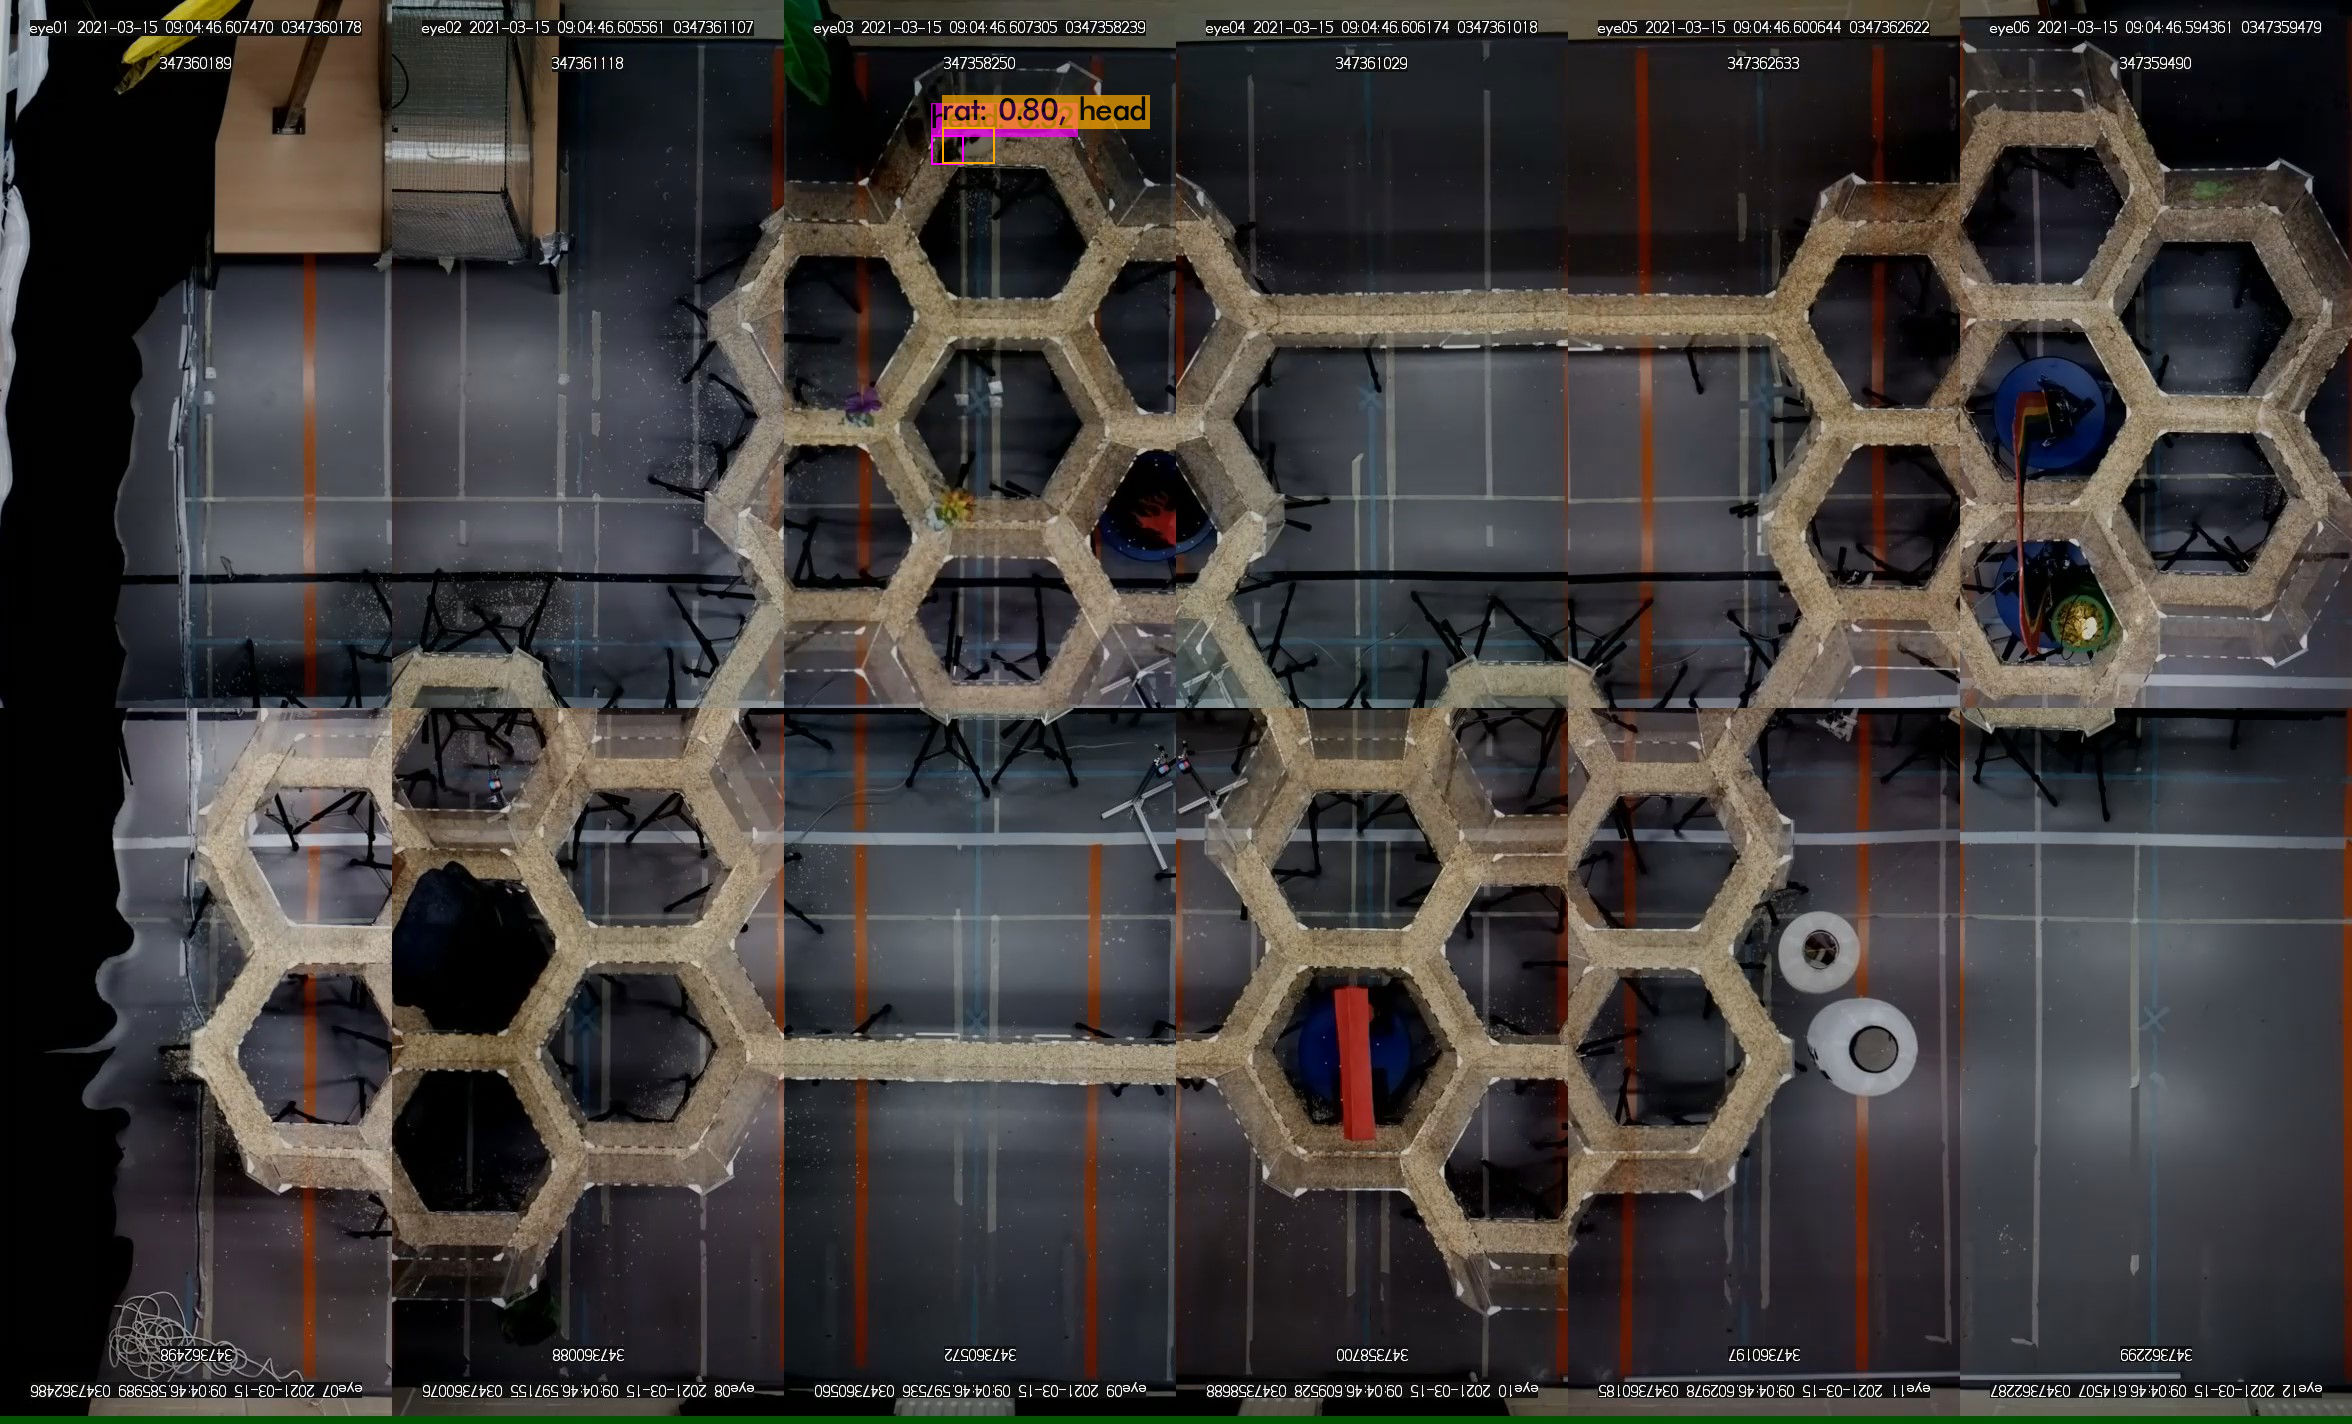

In [ ]:
%cd /content/darknet
!./darknet detector test data/obj.data /content/darknet/cfg/yolov3_training.cfg /content/drive/MyDrive/yolov3/yolov3_training_best.weights /content/darknet/data/image_003362.jpeg
from IPython.display import Image
Image('predictions.jpg')

#**TRACKING WITH YOLO**

## Multithreading and TensorFlow

MULTITHREADING 
In order to use yolo in tensorflow, the .weights file must be converted to ckpt file. First, make sure that yolo_anchors.txt file is under darknet directory. Second, place downloaded yolov3.weights file and yolov3.cfg file under darknet directory

python convert_weight.py
After the command, ckpt file and other necessary files for yolo object detection will be placed under darknet directory.

In order to convert the weight change the number of classes from 80 to 3 in convertweight.py

Before using some repository check tensorflow version (> 1.14) and numpy version==1.16.4  

You can re-calculate anchors, but it is not necessary. You can calculate anchors for Yolo v3 using this command if in your cfg-file width=416 and height=416:
darknet.exe detector calc_anchors data/voc.data -num_of_clusters 9 -width 416 -heigh 416
This anchors you can use in your cfg-file (without multiplication by 32)

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
pip install tensorflow-object-detection-api

In [ ]:
!pip install -r /content/drive/MyDrive/Tracker-Yolov3DeepSort/requirements.txt

In [ ]:
%cd /content/ObjectDetection_MultiThreading_Tensorflow
!python /content/ObjectDetection_MultiThreading_Tensorflow/convert_weight.py

[Errno 2] No such file or directory: '/content/ObjectDetection_MultiThreading_Tensorflow'
/content/darknet/data/obj
python3: can't open file '/content/ObjectDetection_MultiThreading_Tensorflow/convert_weight.py': [Errno 2] No such file or directory


Running Demos
Assuming that video file is under assets directory and yolo weights, ckpt, cfg files under darknet directory. 
Replace /path/to/... part with actual path to files. 
Saving video is set to False as a default, so if you want to save you have to add --save True.

FasterRCNN Tensorflow
python tensorflow_pretrained_multithreading.py \
    --video assets/cars.mp4 \
    --frozen /path/to/frozen_inference_graph.pb \
    --conf 0.5 \
    --save True

  
Yolo Tensorflow
python tensorflow_yolo_tensorflow_pretrained_multithreading.py \
    --video assets/cars.mp4 \
    --ckpt darknet/yolov3.ckpt \
    --conf 0.5 --nms 0.4 \
    --anchor_path darknet/yolo_anchors.txt \
    --save True

In [ ]:
%cd /content/ObjectDetection_MultiThreading_Tensorflow
!python tensorflow_yolo_multithreading.py --video assets/Rat1faildetect.mp4 --ckpt darknet/yolov3.ckpt --conf 0.5 --nms 0.4 --anchor_path darknet/yolo_anchors.txt --save True

In [ ]:
#%cd /content/ObjectDetection_MultiThreading_Tensorflow
!python /content/ObjectDetection_MultiThreading_Tensorflow/tensorflow_yolo_multithreading.py --video /content/drive/MyDrive/yolov3/Rat1faildetect.mp4  --conf 0.5 --save True 

python3: can't open file '/content/ObjectDetection_MultiThreading_Tensorflow/tensorflow_yolo_multithreading.py': [Errno 2] No such file or directory


## DeepSort - object tracking

Run code below to clone deep sort repo
The model has been generated with TensorFlow 1.5. If you run into incompatibility, re-export the frozen inference graph to obtain a new mars-small128.pb that is compatible with your version:

python tools/freeze_model.py

In the top-level directory are executable scripts to execute, evaluate, and visualize the tracker. The main entry point is in deep_sort_app.py. This file runs the tracker on a MOTChallenge sequence.

In package deep_sort is the main tracking code:

detection.py: Detection base class.
kalman_filter.py: A Kalman filter implementation and concrete parametrization for image space filtering.
linear_assignment.py: This module contains code for min cost matching and the matching cascade.
iou_matching.py: This module contains the IOU matching metric.
nn_matching.py: A module for a nearest neighbor matching metric.
track.py: The track class contains single-target track data such as Kalman state, number of hits, misses, hit streak, associated feature vectors, etc.
tracker.py: This is the multi-target tracker class.
The deep_sort_app.py expects detections in a custom format, stored in .npy files. These can be computed from MOTChallenge detections using generate_detections.py. We also provide pre-generated detections.



In [ ]:
pip install --upgrade tf_slim

     |████████████████████████████████| 358kB 22.6MB/s 


In [ ]:
!git clone https://github.com/nwojke/deep_sort.git

Cloning into 'deep_sort'...
remote: Enumerating objects: 141, done.
remote: Total 141 (delta 0), reused 0 (delta 0), pack-reused 141
Receiving objects: 100% (141/141), 67.08 KiB | 3.53 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [ ]:
%cd /content/drive/MyDrive/Tracker-Yolov3DeepSort
!python object_tracker.py 

In [ ]:
##Deep Sort + TensorFlow ['weights in format .tf]

%cd /content/drive/MyDrive/Tracker-Yolov3DeepSort
!python /content/drive/MyDrive/Tracker-Yolov3DeepSort/Tracker-Yolov3-2.py #--video Rat12_1_20200605_stitched.mp4 

In [ ]:
%cd /content/TensorFlow-2.x-YOLOv3
!python /content/TensorFlow-2.x-YOLOv3/object_tracker.py

/content/TensorFlow-2.x-YOLOv3
2021-05-04 11:21:35.141571: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-04 11:21:37.141433: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-04 11:21:37.142519: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-04 11:21:37.165883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-04 11:21:37.166596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-05-04 11:21:37.166642: I tensorflow/stream_e

## Set up environment modules - opecv version 4.5.2 [to use GPU with cv2.dnn.DNN_BACKEND_CUDA]

OpenCV outperforms TF and Darknet.
https://gist.github.com/YashasSamaga/985071dc57885348bec072b4dc23824f 

examples 
https://www.youtube.com/watch?v=KaLo7JTwdDc - [OpenCV DNN CUDA] YOLOv3 on RTX 2080 Ti

The minimum set of dependencies required to use the CUDA backend in OpenCV DNN is:

cudev
opencv_core
opencv_dnn
opencv_imgproc

You might also require the following to read/write/display images and videos:
opencv_imgcodecs
opencv_highgui
opencv_videoio

You will require the following to run the tests:
opencv_ts
opencv_videoio

You also have to set BUILD_TESTS and BUILD_PERF_TESTS.

External Dependencies
The CUDA backend requires CUDA Toolkit (min: 9.2) and cuDNN (min: 7.5) to be installed on the system. CMake will automatically detect CUDA Toolkit and cuDNN when the following options are set:

WITH_CUDA
WITH_CUDNN

The CUDA backend is enabled by setting the following option:
OPENCV_DNN_CUDA

CUDA backend requires CUDA Toolkit (min: 9.2) and cuDNN (min: 7.5) to be installed on the system. CMake will automatically detect CUDA Toolkit and cuDNN when the following options are set:

WITH_CUDA
WITH_CUDNN
The CUDA backend is enabled by setting the following option:

OPENCV_DNN_CUDA
Running tests
Clone opencv_extra repository
cd opencv_extra/testdata/dnn
python3 download_models.py
cd path/to/opencv/repository
cd build
export OPENCV_TEST_DATA_PATH=/path/to/opencv_extra/testdata
Run bin/opencv_test_dnn
Refer to this guide to use perf tests to compare performance between versions

In [ ]:
##Visualize video stream in Colab
%cd /content
!git clone https://code.videolan.org/videolan/x264.git

/content
Cloning into 'x264'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (368/368), done.
remote: Compressing objects: 100% (233/233), done.
remote: Total 22836 (delta 160), reused 340 (delta 135), pack-reused 22468
Receiving objects: 100% (22836/22836), 6.09 MiB | 8.92 MiB/s, done.
Resolving deltas: 100% (18800/18800), done.


In [ ]:
import cv2
cv2.__version__

'4.1.2'

In [ ]:
##Create env with cv2 repo - first time otherwise run cells section below to upload env modules from drive
%cd /content
!git clone https://github.com/opencv/opencv
!git clone https://github.com/opencv/opencv_contrib
!mkdir /content/build
%cd /content/build

!cmake -DOPENCV_EXTRA_MODULES_PATH=/content/opencv_contrib/modules  -DBUILD_SHARED_LIBS=OFF  -DBUILD_TESTS=OFF  -DBUILD_PERF_TESTS=OFF -DBUILD_EXAMPLES=OFF -DWITH_OPENEXR=OFF -DWITH_CUDA=ON -DWITH_CUBLAS=ON -DWITH_CUDNN=ON -DOPENCV_DNN_CUDA=ON /content/opencv
!make -j8 install

In [ ]:
#SaVE ENV file .so in drive to get it later on
#!mkdir  "/content/drive/MyDrive/cv2_gpu" /content/build/lib/python3/cv2.cpython-36m-x86_64-linux-gnu.so
#!cp /usr/local/lib -r "/content/drive/MyDrive/cv2_gpu"
!zip -r /content/lib.zip /usr/local/lib/python3.7/dist-packages/cv2/python-3.7
from google.colab import files
files.download("/content/cv2lib.zip")

In [ ]:
import site, pprint
pprint.pprint(site.getsitepackages())

['/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.7/dist-packages']


# Tracker using yolov3 weights, cv2 dnn with backed cuda [Colab GPU]

### Run cell below to upload from drive cv2 version 4.5.2-dev. 


### Then **restart runtime**

In [ ]:
!cp "/content/drive/MyDrive/cv2_gpu/cv2.cpython-37m-x86_64-linux-gnu.so" . # /usr/local/lib/python3.7/site-packages

In [ ]:
import cv2
cv2.__version__

'4.5.2-dev'

In [ ]:
##Simpler tracker using only opencv DNN and GPU if opencv version 5.4.1 - see above cells to set the env
%cd /content/drive/MyDrive/Tracker-Yolov3DeepSort
!python /content/drive/MyDrive/Tracker-Yolov3DeepSort/TrackerCNN-Colab2.py # -i /content/drive/MyDrive/stitched21.mp4 # Rat12_1_20200605_stitched.mp4 

/content/drive/MyDrive/Tracker-Yolov3DeepSort
Enter unique file name: Colabbis21
#
Lite Tracker version: v2.00
#

creating log files...
Enter num total trials: 8
Enter rat number: 21
Enter date of trial: 0306
Enter GOAL node of session: 207
Enter START node of trial num 1: 113
Enter START node of trial num 2: 406
Enter START node of trial num 3: 302
Enter START node of trial num 4: 124
Enter START node of trial num 5: 405
Enter START node of trial num 6: 315
Enter START node of trial num 7: 101
Enter START node of trial num 8: 424
Network loaded <dnn_Net 0x7ff0b829b5d0>
Number of trials current session 8 
Goal location node  207

Start node trial 1  113 location (993, 64)

Start node trial 2  406 location (263, 337)

Start node trial 3  302 location (631, 162)

Start node trial 4  124 location (912, 304)

Start node trial 5  405 location (344, 575)

Start node trial 6  315 location (475, 161)

Start node trial 7  101 location (1133, 109)

Start node trial 8  424 location (135, 575)
Sta

#Pytorch 

### **Convert yolo .weights file in pytorch format .pt**



In [ ]:
%cd content/drive/MyDrive/Tracker-Yolov3DeepSort
!git clone https://github.com/ultralytics/yolov3

[Errno 2] No such file or directory: 'content/drive/MyDrive/Tracker-Yolov3DeepSort'
/content
Cloning into 'yolov3'...
remote: Enumerating objects: 9852, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 9852 (delta 7), reused 17 (delta 1), pack-reused 9795
Receiving objects: 100% (9852/9852), 9.45 MiB | 31.73 MiB/s, done.
Resolving deltas: 100% (6654/6654), done.


In [ ]:
%cd /content/drive/MyDrive/Tracker-Yolov3DeepSort/yolov3
!python -c "from models import *; convert('/content/drive/MyDrive/Tracker-Yolov3DeepSort/tools/yolov3_training.cfg', '/content/drive/MyDrive/Tracker-Yolov3DeepSort/weights/yolov3_training_best.weights')" 

/content/drive/MyDrive/Tracker-Yolov3DeepSort/yolov3/yolov3
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'models'


In [ ]:
%cd /content/drive/MyDrive/Tracker-Yolov3DeepSort/PyTorch-YOLOv3
#!pip3 install poetry --user
#!poetry install
# convert darknet cfg/weights to pytorch model
!poetry run yolo-test --weights weights/yolov3_training_best.weights weights/yolov3_training_best.pt
#  -c "from models import *; convert('cfg/yolov3_training.cfg', )"
#Success: converted 'weights/yolov3_training_best.weights' to 'yolov3.pt'

# convert cfg/pytorch model to darknet weights
#!python3  -c "from models import *; convert('cfg/yolov3_training.cfg', 'weights/yolov3-spp.pt')"
#Success: converted 'weights/yolov3-spp.pt' to 'converted.weights'

/content/drive/MyDrive/Tracker-Yolov3DeepSort/PyTorch-YOLOv3
/bin/bash: poetry: command not found


In [ ]:
##Pytorch-Darknet version weights in format .pt [require clone of yolov3 and darknet repositiory]
%cd /content/drive/MyDrive/Tracker-Yolov3DeepSort
!python /content/drive/MyDrive/Tracker-Yolov3DeepSort/TrackerCNN-Pytorch2.py -i Rat12_1_20200605_stitched.mp4 

/content/drive/MyDrive/Tracker-Yolov3DeepSort
Traceback (most recent call last):
  File "/content/drive/MyDrive/Tracker-Yolov3DeepSort/TrackerCNN-Pytorch2.py", line 32, in <module>
    import torch
  File "/usr/local/lib/python3.7/dist-packages/torch/__init__.py", line 196, in <module>
    from torch._C import *
RuntimeError: KeyboardInterrupt: 


In [ ]:
import torch
def try_gpu(i=0):  
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    devices = [
        torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

ERROR: torch-0.4.1-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.
     |████████████████████████████████| 804.1MB 23kB/s 


In [ ]:
#PyTorch version that supports CUDA 10.0 via 
#!pip install torch + cuda
from os import path
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

print(torch.cuda.device_count())
accelerator = 'cu80' #'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print( 'Accelerator:', accelerator)

!pip install --upgrade --force-reinstall -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

import torch
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
#!pip install pytorch-cpu torchvision-cpu -c pytorch

1
Accelerator: cu80
ERROR: torch-0.4.0-{platform}-linux_x86_64.whl is not a valid wheel filename.
Torch 1.8.1+cu101 CUDA 10.1
Device: cuda:0
